# Time series forecasting

### Data loading

First we import the libraries used in the project. They can be found in the **lib/** folder

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')
tfk = tf.keras
tfkl = tf.keras.layers

# Import library
import lib.utils as util
import lib.loaders as loaders
import lib.models as m


In [2]:
# Set seed
seed = 42
util.set_seed(seed)
model_path = "saved_models/"
model_name = "model5"

Then we set up the config file which contains all the training necessary for data fetching and training.

In [3]:
config = {
    "batch_size" : 32,
    "val_split" : 0.1,
    "add_features": True,
    # Parameters for windowing
    "window" : 200,
    "stride" : 10,
    "telescope" : 96,
    # Parameters for data normalization
    "normalization_mode" : 0 # 0 for zero-mean and unit-variance. 1 for normalize to range [0,1]
    }

Then we can load the data and make a few plots

In [4]:
data_path = 'data/Training.csv'

X, X_train_raw, X_val_raw, X_train, y_train, X_val, y_val, norms  = loaders.get_datasets(
    data_path = data_path, 
    config = config
    )
train_dataset, val_dataset = loaders.get_loaders(
    X_train, y_train, X_val, y_val,config)

# Save the normalization parameters
config['norms'] = norms

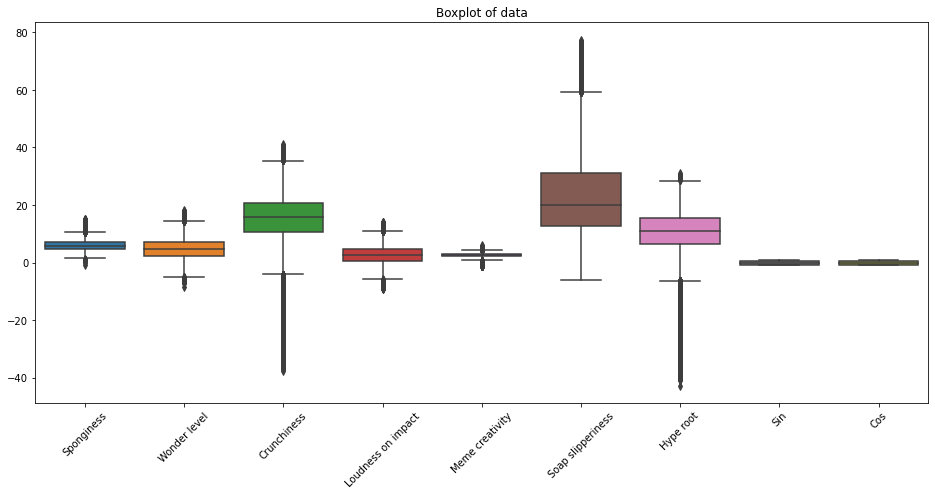

In [5]:
f,ax = util.plot_boxplot(X, figsize=(16,7))
plt.show()

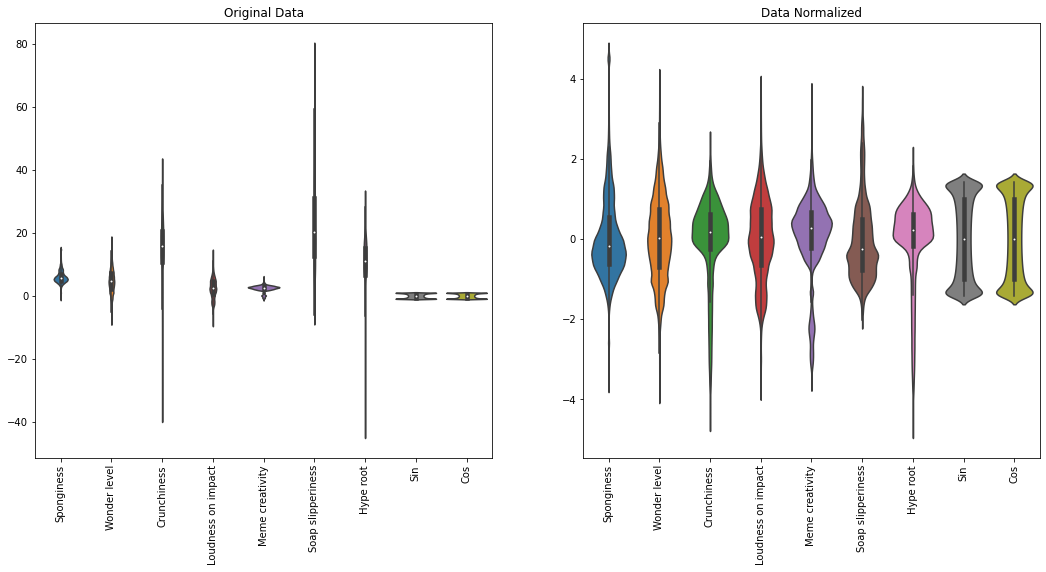

In [6]:
f,ax = util.plot_normalized_data(X, norms, figsize=(18,8))
plt.show()

### Model setup

We can then load the model

In [7]:
epochs = 200
input_shape = (config["window"],X.shape[1])
output_shape = (config["telescope"],7)

# Build model
#model = m.build_model3(input_shape, output_shape)
model = m.build_encoder_decoder(input_shape,output_shape, 
                          latent_dim = 96,
                          dropout = 0.3)

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 past_inputs (InputLayer)       [(None, 200, 9)]     0           []                               
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 200, 7)      0           ['past_inputs[0][0]']            
 ingOpLambda)                                                                                     
                                                                                                  
 lstm (LSTM)                    [(None, 96),         40704       ['past_inputs[0][0]']            
                                 (None, 96),                                                      
                                 (None, 96)]                                                  

Then we can finally train the model

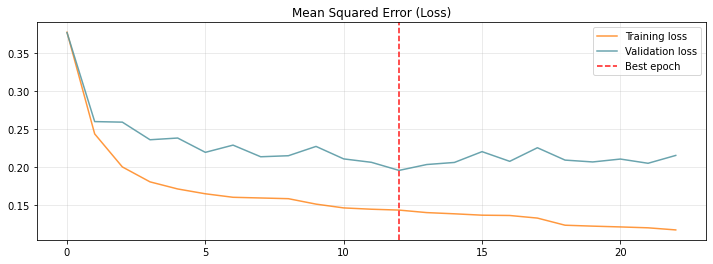

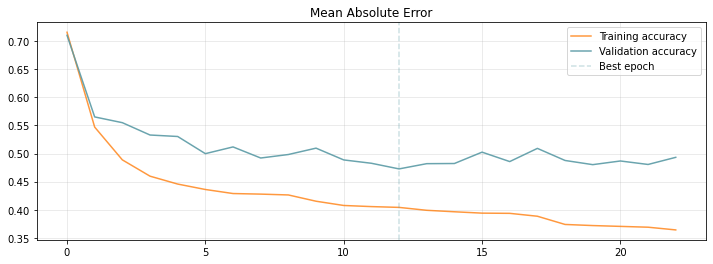

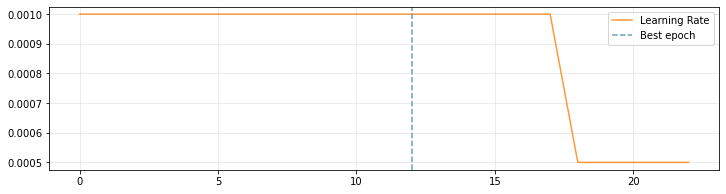

In [9]:
model_hist = model.fit(
    x = X_train,
    y = y_train,
    batch_size = config["batch_size"],
    epochs = epochs,
    validation_data = [X_val, y_val],
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ],
    verbose = 0
).history

# add history to config
config.update(model_hist)

# Plot the training
util.plotTraining(config)

### Visualize training results

We can then visualize the models performance on a subsection of the validation set. In this example we have used forcasting, such that the model increasingly makes predictions only using its own previous outputs.

100%|████████████████████████████████████████████| 9/9 [00:01<00:00,  7.26it/s]


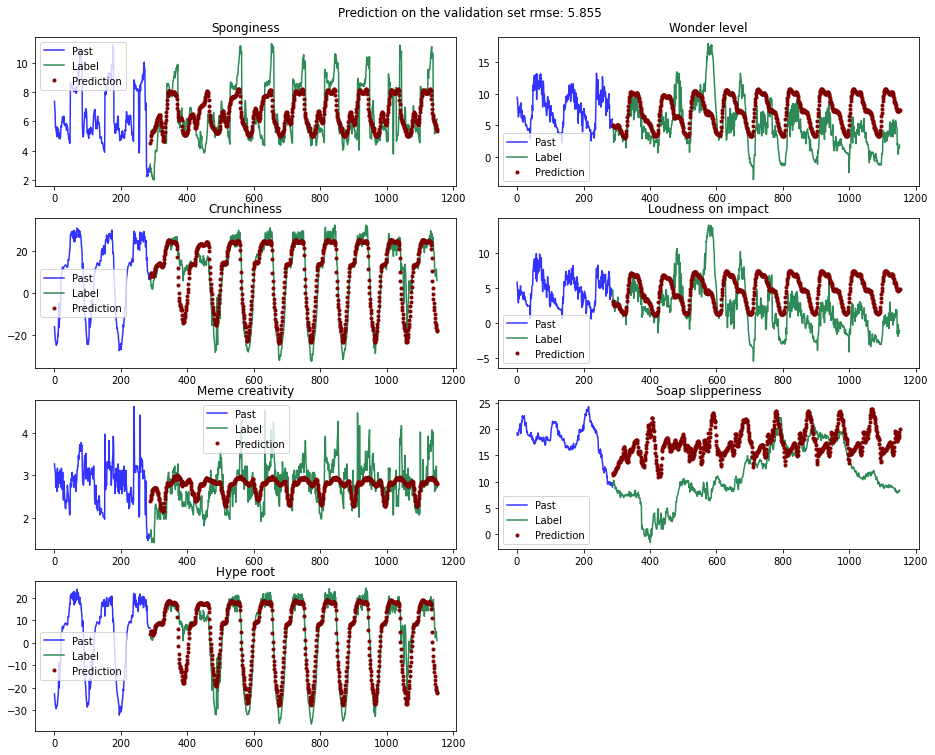

In [10]:
f,ax = util.show_predictions(model,X, config, 
                      mode = "val",
                      N_predictions = 864, 
                      ASSISTED = False, 
                      post_processing=True)
plt.show()

If we like the model we can save it here

In [11]:
# model.save(model_path + model_name)
# np.save(model_path + model_name+"_hist.npy", config) 

### Load previous model and visualize its predicted future

We start by loading a saved model from the submission folder

In [12]:
from submissions.submission5.model import model
path = "submissions/submission5/"
submodel = model(path)


Then we re-load the data such that the X input is of size $[68528,7]$ and un-normalized

In [13]:
data_path = 'data/Training.csv'

# config['add_features'] = False
X, _, _, _, _, _, _, _  = loaders.get_datasets(
    data_path = data_path, 
    config = submodel.config
    )
X = tf.convert_to_tensor(X)
X_pure = X[:,:7] # only give the 7 first values to the model

And try to pass the data to the model

In [14]:
pred = submodel.predict(X_pure)

assert pred.shape == (864,7)

Then we visualize the models predictions on Phase 1 and Phase 2 of the future

100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 17.16it/s]


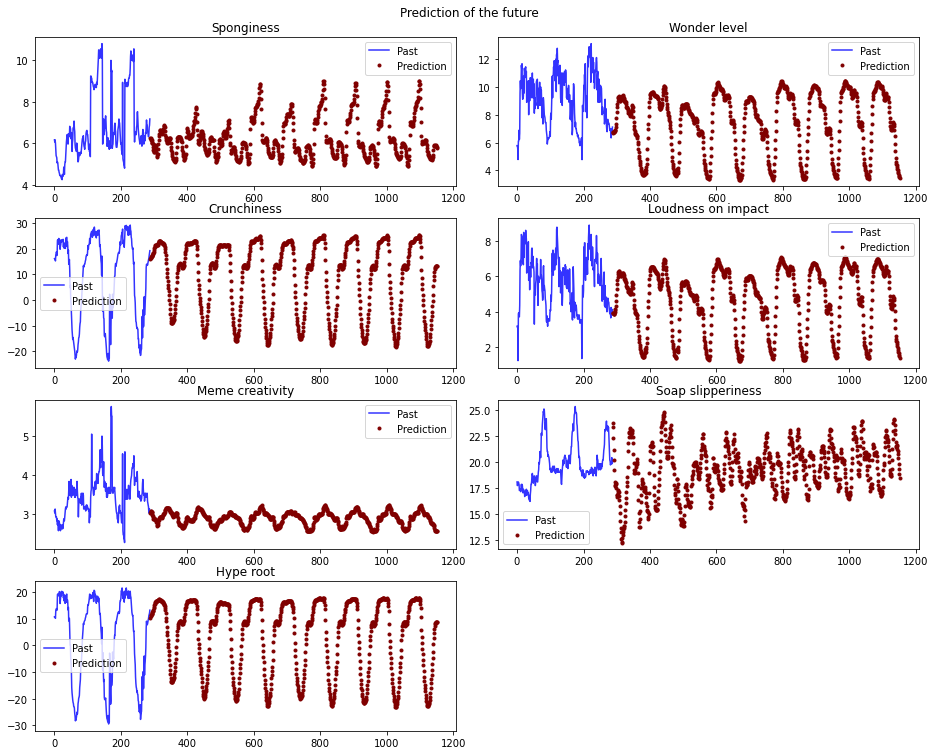

In [15]:
f,ax = util.show_predictions(submodel.model,X, config, 
                      mode = "future",
                      N_predictions = 864, 
                      ASSISTED = False, 
                      post_processing=True)
plt.show()

100%|██████████████████████████████████████████| 12/12 [00:00<00:00, 13.13it/s]


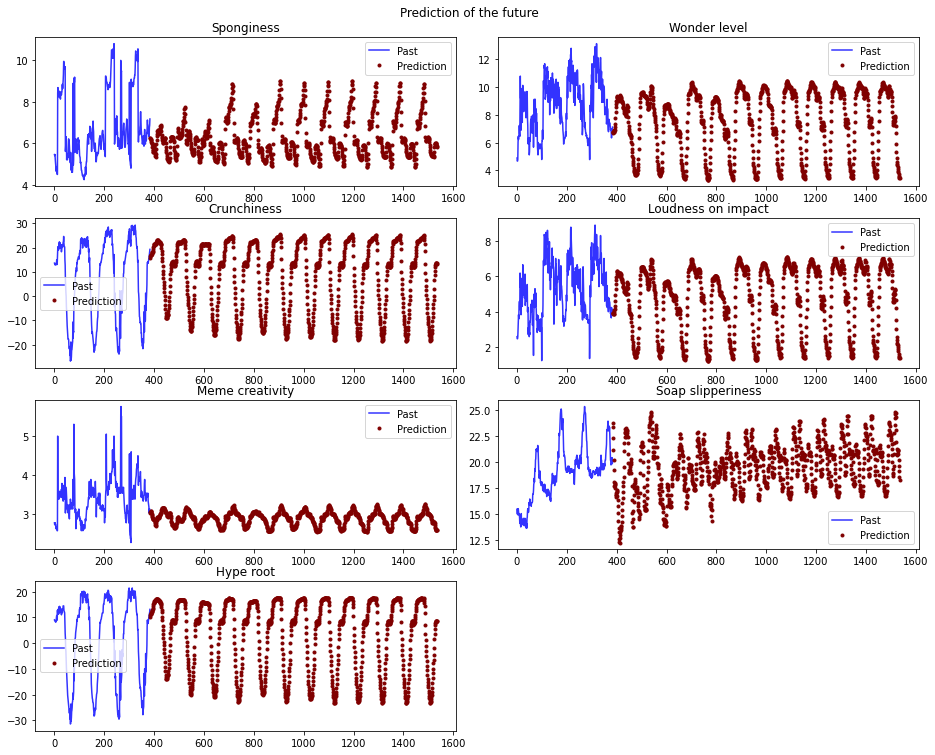

In [16]:
f,ax = util.show_predictions(submodel.model,X, config, 
                      mode = "future",
                      N_predictions = 1152, 
                      ASSISTED = False, 
                      post_processing=True)
plt.show()